# 走れメロスっぽい文ジェネレータ

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## 環境を整備しましょう

In [2]:
%%bash

apt-get install -y mecab mecab-ipadic-utf8 libmecab-dev unzip nkf

Reading package lists...
Building dependency tree...
Reading state information...
libmecab-dev is already the newest version.
mecab is already the newest version.
mecab-ipadic-utf8 is already the newest version.
nkf is already the newest version.
unzip is already the newest version.
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [3]:
!pip install mecab-python

Cleaning up...


## データを用意しましょう

In [4]:
%%bash

mkdir -p /jupyter/data/dazai
cd /jupyter/data/dazai

if [ ! -e 1567_ruby_4948.zip ]; then
    wget http://www.aozora.gr.jp/cards/000035/files/1567_ruby_4948.zip
    unzip 1567_ruby_4948.zip
fi

### UTF8に変換

In [5]:
cd /jupyter/data/dazai

/jupyter/data/dazai


In [6]:
%%bash
nkf -w < hashire_merosu.txt > hashire_merosu.utf8.txt

### 文切り・形態素解析(単語分割)

In [7]:
with open("hashire_merosu.utf8.txt") as fp:
    data = fp.read()

In [8]:
data = data.replace("\r", "").split("\n")[16:-15]

In [9]:
import re

def sentence_split(data):
    splitted = data.replace("。", "。\n")
    splitted = splitted.replace("」", "」\n")
    splitted = splitted.replace("！", "！\n")
    splitted = splitted.replace("？", "？\n")
    splitted = splitted.replace("。\n」\n", "。」\n")
    par = re.compile(r"「.*?」", re.DOTALL)
    match = par.findall(splitted)
    for m in match:
        replaced = m.replace("\n", "")
        splitted = splitted.replace(m, replaced)
        
    par = re.compile(r"（.*?）", re.DOTALL)
    match = par.findall(splitted)
    for m in match:
        replaced = m.replace("\n", "")
        splitted = splitted.replace(m, replaced)
        
    return filter(lambda line: line != "", splitted.split("\n"))

In [10]:
corpus = []
for line in data:
    corpus += sentence_split(line)

In [11]:
def normalize(line):
    line = line.replace("　", " ")
    line = re.sub("《.*?》", "", line)
    return line.strip()

In [12]:
corpus = [normalize(line) for line in corpus]

In [13]:
import MeCab

In [14]:
tagger = MeCab.Tagger("-Owakati")

In [15]:
wordss = []
for line in corpus:
    wordss.append(tagger.parse(line).replace("\n", "").split(" "))

In [16]:
for words in wordss[:5]:
    print " ".join(words)

メロス は 激怒 し た 。 
必ず 、 かの 邪智 暴虐 の 王 を 除か なけれ ば なら ぬ と 決意 し た 。 
メロス に は 政治 が わから ぬ 。 
メロス は 、 村 の 牧人 で ある 。 
笛 を 吹き 、 羊 と 遊ん で 暮し て 来 た 。 


## 単語辞書を用意しましょう

In [17]:
import itertools as it

In [18]:
vocab = set(it.chain.from_iterable(wordss))
vocab = dict([(word, i + 2) for i, word in enumerate(vocab)] + [("<unk>", 0), ("</s>", 1)])

## モデルを作りましょう

In [19]:
import chainer
from chainer import functions as F
from chainer import links as L
from chainer import optimizers as O
from chainer import optimizer
from chainer.link import Chain
from chainer import Variable
import numpy as np
import cupy

In [20]:
class LM(Chain):
    def __init__(self, n_vocab):
        super(LM, self).__init__(
            embed=L.EmbedID(n_vocab, 100),
            lstm1=L.LSTM(100, 50),
            lstm2=L.LSTM(50, 50),
            out=L.Linear(50, n_vocab),
        )
        
        self.n_vocab = n_vocab
        
        self.dropout_ratio = 0.5
        self.train = False
        self.softmax = lambda x: x
    
    def reset_state(self):
        self.lstm1.reset_state()
        self.lstm2.reset_state()
    
    def __call__(self, x):
        h = self.embed(x)
        h = self.lstm1(h)
        h = F.dropout(h, ratio=self.dropout_ratio, train=self.train)
        h = self.lstm2(h)
        h = F.dropout(h, ratio=self.dropout_ratio, train=self.train)
        y = self.out(h)
        y = self.softmax(y)
        
        return y

In [21]:
def corpus_to_id_vector(list_of_words, vocab_dict):
    longest = max([len(words) for words in list_of_words]) + 1
    id_vec = np.empty((len(list_of_words), longest), dtype=np.int32)
    for i, words in enumerate(list_of_words):
        for j, word in enumerate(words):
            id_vec[i, j] = vocab_dict[word]
        
        for j in xrange(len(words), longest):
            id_vec[i, j] = vocab_dict["</s>"]
            
    return id_vec

In [22]:
def forward_all(ids, classifier, train=False):
    loss = 0
    for pos in xrange(ids.shape[1] - 1):
        x = Variable(ids[:, pos], volatile=not train)
        t = Variable(ids[:, pos + 1], volatile=not train)
        loss += classifier(x, t)
        
    return loss

In [23]:
def test(model, n_words=10):
    model.reset_state()
    word = "メロス"
    ret = []
    for i in xrange(n_words):
        ret.append(word)
        word_id = vocab[word]
        y = model(Variable(cupy.array([word_id], dtype=np.int32), volatile=True))
        next_word_id = y.data[0].argmax()
        word = filter(lambda (i, v): v == next_word_id, vocab.iteritems())[0][0]
    return ret

In [24]:
lm = LM(len(vocab))

In [25]:
id_vec = corpus_to_id_vector(wordss, vocab)

In [26]:
id_vec = chainer.cuda.to_gpu(id_vec, device=1)
classifier = L.Classifier(lm)
classifier.to_gpu(1)

/usr/local/lib/python2.7/dist-packages/chainer/cuda.py:85: UserWarning: cuDNN is not enabled.
Please reinstall chainer after you install cudnn
(see https://github.com/pfnet/chainer#installation).
  'cuDNN is not enabled.\n'


In [27]:
opt = O.AdaDelta()
opt.setup(classifier)
opt.add_hook(optimizer.GradientClipping(5))

In [28]:
history = []
lm.train = True
classifier.compute_accuracy = False
with cupy.cuda.Device(1):
    for i in xrange(2000):
        lm.reset_state()
        opt.zero_grads()

        loss = forward_all(id_vec, classifier, train=True)
        loss.backward()
        opt.update()
        if i % 20 == 0:
            print "[{0}] Loss={1}".format(i, loss.data)
        loss.to_cpu()
        history.append(loss.data)
        if i % 100 == 0:
            lm.train = False
            print " ".join(test(lm))
            lm.train = True

[0] Loss=1041.6340332
メロス 疑い 疑い 幽か 皇后 幽か 血液 激怒 夜明け こんど
[20] Loss=126.401634216
[40] Loss=91.8752059937
[60] Loss=83.6573867798
[80] Loss=79.0079650879
[100] Loss=75.7060699463
メロス は 、 、 私 を 、 、 私 を
[120] Loss=72.9556732178
[140] Loss=70.7351379395
[160] Loss=68.2887878418
[180] Loss=66.5264129639
[200] Loss=64.8943328857
メロス は 、 メロス は 、 メロス の だ 。
[220] Loss=63.5608100891
[240] Loss=62.2335510254
[260] Loss=61.1006889343
[280] Loss=59.3960418701
[300] Loss=58.0964126587
メロス は 、 私 の 間 を 、 ここ に
[320] Loss=56.8628883362
[340] Loss=55.9995155334
[360] Loss=55.0843849182
[380] Loss=53.8716697693
[400] Loss=52.8403282166
メロス は 、 私 を 信じ た 。  </s>
[420] Loss=51.3962554932
[440] Loss=50.8320732117
[460] Loss=49.9990959167
[480] Loss=49.0964546204
[500] Loss=48.1239089966
メロス は 、 いま は 、 メロス の 友 を
[520] Loss=47.2607803345
[540] Loss=46.5658187866
[560] Loss=46.3780975342
[580] Loss=45.313495636
[600] Loss=44.6560707092
メロス は 、 いま は 、 メロス の 男 を
[620] Loss=43.8787193298
[640] Loss=43.7033538818
[660

In [29]:
import pandas as pd

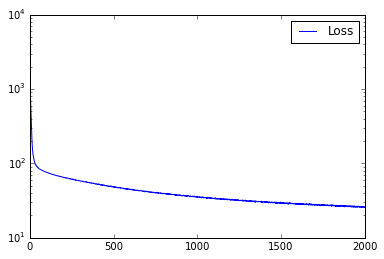

In [30]:
pd.DataFrame(history, columns=['Loss']).plot(logy=True)

In [31]:
def sample(model, first="メロス", n_words=100):
    model.reset_state()
    word = first
    ret = []
    for i in xrange(n_words):
        ret.append(word)
        word_id = vocab[word]
        y = model(Variable(cupy.array([word_id], dtype=np.int32), volatile=True))
        next_word_dist = np.array(cupy.asnumpy(y.data[0]), dtype=np.float)
        next_word_dist /= next_word_dist.sum()
        next_word_id = np.random.choice(len(vocab), 1, p=list(next_word_dist))[0]
        word = filter(lambda (i, v): v == next_word_id, vocab.iteritems())[0][0]
    return ret

In [32]:
lm.train=False
lm.softmax = F.softmax

In [33]:
with cupy.cuda.Device(1):
    print " ".join(sample(lm, first="メロス"))

メロス は 、 待つ 声 で 、 何 を 泣き ながら 希望 の まま 。 言え 。  </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>


In [34]:
with cupy.cuda.Device(1):
    print " ".join(sample(lm, first="メロス"))

メロス を 、 はじめて 身代り の 肩 を 取り直し て 、 口 が 出 た が い て 、 ほっと て やり なけれ ば なら ぬ 。  </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>


In [35]:
with cupy.cuda.Device(1):
    print " ".join(sample(lm, first="国王"))

国王 は 友 と も 、 母 も 無い 。  </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>


In [36]:
with cupy.cuda.Device(1):
    print " ".join(sample(lm, first="国王"))

国王 は 沈ま て なら ぬ 。  </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>


In [37]:
with cupy.cuda.Device(1):
    print " ".join(sample(lm, first="メロス"))

メロス は 、 今宵 、 寝過し でも 、 どう でも いい 。  </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>


In [38]:
with cupy.cuda.Device(1):
    print " ".join(sample(lm, first="メロス"))

メロス は 、 王 の 士 まで に の からだ を 開始 し た 。  </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>
